In [3]:
import pandas as pd
import pymc as pm
import aesara.tensor as at
from sklearn.model_selection import train_test_split
import logging
from sklearn.metrics import mean_squared_error

# Initialize logging
logging.basicConfig(filename='hierarchical_model.log', level=logging.INFO)

try:
    logging.info('Loading data...')
    # Your preprocessed merged data
    df = pd.read_csv('etf_data/preprocessed_merged_data.csv')
    etf_groups = df['ETF'].unique()
    n_etfs = len(etf_groups)

    # Map ETFs to indices for hierarchical modeling
    df['ETF_idx'] = df['ETF'].map({etf: i for i, etf in enumerate(etf_groups)})

    logging.info('Preparing data...')
    selected_features = [col for col in df.columns if col not in [
        'ETF', 'Close', 'Date', 'ETF_idx']]
    X_train, X_test, y_train, y_test = train_test_split(
        df[selected_features], df['Close'], test_size=0.2, stratify=df['ETF_idx'])

    etf_idx_train = df.loc[X_train.index, 'ETF_idx']
    etf_idx_test = df.loc[X_test.index, 'ETF_idx']

    logging.info('Building hierarchical model...')
    with pm.Model() as hierarchical_model:
        
        # Convert DataFrame to tensor
        X_train_tensor = at.as_tensor_variable(X_train.values.astype('float64'))

        # Hyperpriors
        mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=1)
        sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=1)

        mu_beta = pm.Normal('mu_beta', mu=0, sigma=1)
        sigma_beta = pm.HalfNormal('sigma_beta', sigma=1)

        # ETF-level random intercepts
        alpha = pm.Normal('alpha', mu=mu_alpha,
                          sigma=sigma_alpha, shape=n_etfs)

        # Fixed slopes for each predictor
        beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_beta,
                         shape=len(selected_features))

        # Model error
        sigma = pm.HalfNormal('sigma', sigma=1)

        # Expected value
        mu = alpha[etf_idx_train] + at.dot(X_train_tensor, beta)

        # Data likelihood
        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_train)

        # Sampling
        trace = pm.sample(500, tune=200, target_accept=0.9, cores=4)

        # WAIC for model comparison
        waic = pm.waic(trace, scale='deviance')
        logging.info(f'WAIC: {waic.waic}')

    logging.info('Model trained.')

    # Posterior Predictive Checks
    ppc = pm.sample_posterior_predictive(
        trace, model=hierarchical_model, samples=500)
    y_pred = ppc['y_obs'].mean(axis=0)

    mse = mean_squared_error(y_test, y_pred)
    logging.info(f'Mean Squared Error: {mse}')

except Exception as e:
    logging.error(f'An error occurred: {e}')


In [5]:
import pandas as pd
import pymc as pm
import aesara.tensor as at
from sklearn.model_selection import train_test_split
import logging
from sklearn.metrics import mean_squared_error

# Initialize logging
logging.basicConfig(filename='hierarchical_model.log', level=logging.INFO)

try:
    logging.info('Loading data...')
    
    # Assuming your preprocessed merged data is stored in 'preprocessed_merged_data.csv'
    df = pd.read_csv('etf_data/preprocessed_merged_data.csv')  
    etf_groups = df['ETF'].unique()
    n_etfs = len(etf_groups)

    # Map ETFs to indices for hierarchical modeling
    df['ETF_idx'] = df['ETF'].map({etf: i for i, etf in enumerate(etf_groups)})

    logging.info('Preparing data...')
    
    # Here, 'Close' is considered as the target variable. You can change it as per your specific goal.
    selected_features = [col for col in df.columns if col not in ['Date', 'ETF', 'ETF_idx', 'Close']]
    X_train, X_test, y_train, y_test = train_test_split(df[selected_features], df['Close'], test_size=0.2, stratify=df['ETF_idx'])

    etf_idx_train = df.loc[X_train.index, 'ETF_idx']
    etf_idx_test = df.loc[X_test.index, 'ETF_idx']

    logging.info('Building hierarchical model...')
    with pm.Model() as hierarchical_model:
        
        # Hyperpriors
        mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=1)
        sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=1)
        
        mu_beta = pm.Normal('mu_beta', mu=0, sigma=1)
        sigma_beta = pm.HalfNormal('sigma_beta', sigma=1)
        
        # ETF-level random intercepts
        alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha, shape=n_etfs)
        
        # Fixed slopes for each predictor
        beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_beta, shape=len(selected_features))
        
        # Model error
        sigma = pm.HalfNormal('sigma', sigma=1)
        
        # Convert DataFrame to tensor
        X_train_tensor = at.as_tensor_variable(X_train.values.astype('float64'))
        
        # Expected value
        mu = alpha[etf_idx_train] + at.dot(X_train_tensor, beta)
        
        # Data likelihood
        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_train)

        # Sampling
        trace = pm.sample(500, tune=200, target_accept=0.9, cores=4)
        
        # WAIC for model comparison
        waic = pm.waic(trace, scale='deviance')
        logging.info(f'WAIC: {waic.waic}')

    logging.info('Model trained.')
    
    # Posterior Predictive Checks
    ppc = pm.sample_posterior_predictive(trace, model=hierarchical_model, samples=500)
    y_pred = ppc['y_obs'].mean(axis=0)
    
    mse = mean_squared_error(y_test, y_pred)
    logging.info(f'Mean Squared Error: {mse}')

except Exception as e:
    logging.error(f'An error occurred: {e}')


In [ ]:
# Below code without using aesara so beta,tensor variable error coming up

In [6]:
import pandas as pd
import pymc as pm
from sklearn.model_selection import train_test_split
import logging
from sklearn.metrics import mean_squared_error

# Initialize logging
logging.basicConfig(filename='hierarchical_model.log', level=logging.INFO)

try:
    logging.info('Loading data...')
    df = pd.read_csv('etf_data/preprocessed_merged_data.csv')
    etf_groups = df['ETF'].unique()
    n_etfs = len(etf_groups)

    df['ETF_idx'] = df['ETF'].astype('category').cat.codes

    logging.info('Preparing data...')
    selected_features = [col for col in df.columns if col not in ['Date', 'ETF', 'Close', 'ETF_idx']]
    X = df[selected_features].values
    y = df['Close'].values
    etf_idx = df['ETF_idx'].values

    X_train, X_test, y_train, y_test, etf_idx_train, etf_idx_test = train_test_split(X, y, etf_idx, test_size=0.2, stratify=etf_idx)

    logging.info('Building hierarchical model...')
    with pm.Model() as hierarchical_model:

        # Hyperpriors
        mu_alpha = pm.Normal('mu_alpha', mu=0., sigma=1)
        sigma_alpha = pm.HalfCauchy('sigma_alpha', beta=1)
        
        mu_beta = pm.Normal('mu_beta', mu=0., sigma=1)
        sigma_beta = pm.HalfCauchy('sigma_beta', beta=1)
        
        # ETF-level random intercepts
        alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha, shape=n_etfs)
        
        # Fixed effects.
        beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_beta, shape=(X_train.shape[1],))
        
        # Model error
        sigma = pm.HalfCauchy('sigma', beta=1)
        
        # Expected value
        mu = alpha[etf_idx_train] + pm.math.dot(X_train, beta)
        
        # Data likelihood
        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_train)

        trace = pm.sample(500, tune=200, cores=4, target_accept=0.9)

        waic = pm.waic(trace, scale='deviance')
        logging.info(f'WAIC: {waic.waic}')

    logging.info('Model trained.')
    
    # Posterior Predictive Checks
    with hierarchical_model:
        ppc = pm.sample_posterior_predictive(trace, samples=500)
    y_pred = ppc['y_obs'].mean(axis=0)
    
    mse = mean_squared_error(y_test, y_pred)
    logging.info(f'Mean Squared Error: {mse}')

except Exception as e:
    logging.error(f'An error occurred: {e}')



C:\Users\saide\anaconda3\envs\pymc_env\Lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


In [ ]:
Above code works well and few rows do have null values/empty places in preprocessed merged data, updated code is below.

In [3]:
import pandas as pd
import pymc as pm
from sklearn.model_selection import train_test_split
import logging
from sklearn.metrics import mean_squared_error

# Initialize logging
logging.basicConfig(filename='hierarchical_model.log', level=logging.INFO)

try:
    logging.info('Loading data...')
    df = pd.read_csv('etf_data/preprocessed_merged_data.csv')
    df.dropna(inplace=True)  # Remove NaN values
    
    etf_groups = df['ETF'].unique()
    n_etfs = len(etf_groups)

    df['ETF_idx'] = df['ETF'].astype('category').cat.codes

    logging.info('Preparing data...')
    selected_features = [col for col in df.columns if col not in ['Date', 'ETF', 'Close', 'ETF_idx']]
    X = df[selected_features].values
    y = df['Close'].values
    etf_idx = df['ETF_idx'].values

    X_train, X_test, y_train, y_test, etf_idx_train, etf_idx_test = train_test_split(X, y, etf_idx, test_size=0.2, stratify=etf_idx)

    logging.info('Building hierarchical model...')
    with pm.Model() as hierarchical_model:

        # Hyperpriors
        mu_alpha = pm.Normal('mu_alpha', mu=0., sigma=1)
        sigma_alpha = pm.HalfCauchy('sigma_alpha', beta=1)
        
        mu_beta = pm.Normal('mu_beta', mu=0., sigma=1)
        sigma_beta = pm.HalfCauchy('sigma_beta', beta=1)
        
        # ETF-level random intercepts
        alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha, shape=n_etfs)
        
        # Fixed effects.
        beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_beta, shape=(X_train.shape[1],))
        
        # Model error
        sigma = pm.HalfCauchy('sigma', beta=1)
        
        # Expected value
        mu = alpha[etf_idx_train] + pm.math.dot(X_train, beta)
        
        # Data likelihood
        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_train)
        
        # Debugging
#         model_debug = pm.model_to_graphviz(hierarchical_model)
#         model_debug.render(filename='model_debug', format='png', cleanup=True)

        trace = pm.sample(500, tune=200, cores=4, target_accept=0.9, init='adapt_diag')

        waic = pm.waic(trace, scale='deviance')
        logging.info(f'WAIC: {waic.waic}')

    logging.info('Model trained.')
    
    # Posterior Predictive Checks
    with hierarchical_model:
        ppc = pm.sample_posterior_predictive(trace, samples=500)
    y_pred = ppc['y_obs'].mean(axis=0)
    
    mse = mean_squared_error(y_test, y_pred)
    logging.info(f'Mean Squared Error: {mse}')

except Exception as e:
    logging.error(f'An error occurred: {e}')


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_beta, sigma_beta, alpha, beta, sigma]


Sampling 4 chains for 200 tune and 500 draw iterations (800 + 2_000 draws total) took 1335 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


### What I do have completed till now:

Data Loading and Preprocessing: Loaded the ETF data from a CSV file and preprocessed it by handling missing values and mapping ETFs to indices.

Feature Selection: Selected relevant features for the model.

Data Splitting: Divided the data into training and test sets.

Model Building: Built a hierarchical Bayesian model using PyMC3. The model includes both fixed and random effects to account for the hierarchical nature of the data.

Model Training: Trained the model using MCMC sampling.

Model Evaluation: Evaluated the model using WAIC (Watanabe-Akaike Information Criterion) and stored it in the log.

Posterior Predictive Checks: Generated posterior predictive checks to ensure that the model replicates the observed data well.

Prediction and MSE: Made predictions on the test set and calculated the Mean Squared Error (MSE).

Logging: All significant steps and errors are being logged for later analysis.

C:\Users\saide\anaconda3\envs\pymc_env\Lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a

Sampling 4 chains for 200 tune and 500 draw iterations (800 + 2_000 draws total) took 940 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


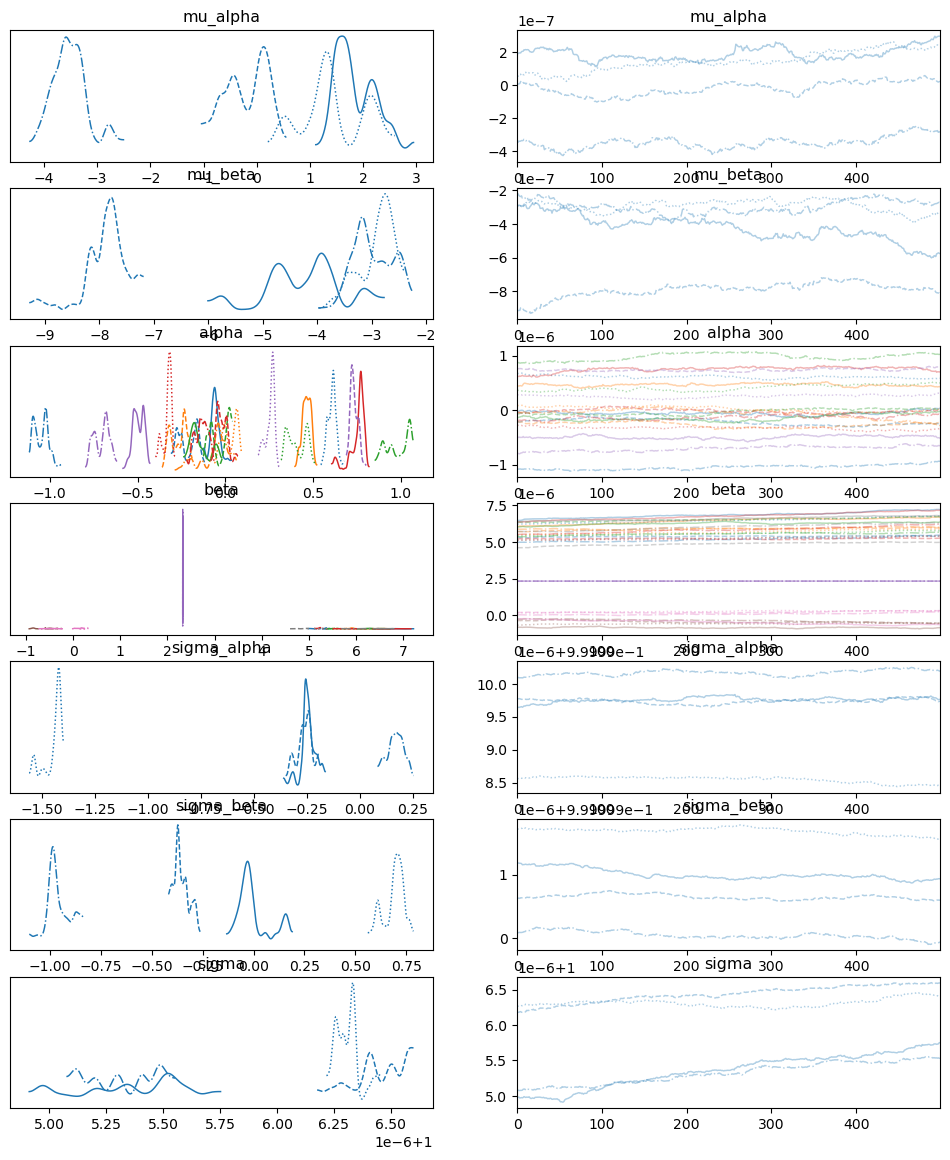

In [6]:
import pandas as pd
import pymc as pm
import logging
import matplotlib.pyplot as plt
import arviz as az
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Initialize logging
logging.basicConfig(filename='hierarchical_model_1.log', level=logging.INFO)

try:
    logging.info('Loading data...')
    df = pd.read_csv('etf_data/preprocessed_merged_data.csv')
    df.dropna(inplace=True)
    
    etf_groups = df['ETF'].unique()
    n_etfs = len(etf_groups)

    df['ETF_idx'] = df['ETF'].astype('category').cat.codes

    logging.info('Preparing data...')
    selected_features = [col for col in df.columns if col not in ['Date', 'ETF', 'Close', 'ETF_idx']]
    X = df[selected_features].values
    y = df['Close'].values
    etf_idx = df['ETF_idx'].values

    X_train, X_test, y_train, y_test, etf_idx_train, etf_idx_test = train_test_split(X, y, etf_idx, test_size=0.2, stratify=etf_idx)

    logging.info('Building hierarchical model...')
    with pm.Model() as hierarchical_model:

        # Hyperpriors
        mu_alpha = pm.Normal('mu_alpha', mu=0., sigma=1)
        sigma_alpha = pm.HalfCauchy('sigma_alpha', beta=1)
        mu_beta = pm.Normal('mu_beta', mu=0., sigma=1)
        sigma_beta = pm.HalfCauchy('sigma_beta', beta=1)
        
        # ETF-level random intercepts
        alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha, shape=n_etfs)
        
        # Fixed effects
        beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_beta, shape=(X_train.shape[1],))
        
        # Model error
        sigma = pm.HalfCauchy('sigma', beta=1)
        
        # Expected value
        mu = alpha[etf_idx_train] + pm.math.dot(X_train, beta)
        
        # Data likelihood
        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_train)

        trace = pm.sample(500, tune=200, cores=4, target_accept=0.9, init='adapt_diag')

        # Diagnostic Checks: Trace Plots
        logging.info('Plotting trace plots...')
        az.plot_trace(trace)
        plt.savefig('trace_plots.png')

        # WAIC and Model Comparison
        waic = pm.waic(trace, scale='deviance')
        logging.info(f'WAIC: {waic.waic}')
        
        # Posterior Predictive Checks
        logging.info('Performing posterior predictive checks...')
        ppc = pm.sample_posterior_predictive(trace, samples=500)
        y_pred = ppc['y_obs'].mean(axis=0)

        # Mean Squared Error
        mse = mean_squared_error(y_test, y_pred)
        logging.info(f'Mean Squared Error: {mse}')

        # Save Model
        logging.info('Saving the model...')
        with open('hierarchical_model.pkl', 'wb') as f:
            pickle.dump({'model': hierarchical_model, 'trace': trace}, f)

    logging.info('Model trained and saved.')

except Exception as e:
    logging.error(f'An error occurred: {e}')

    # Next Steps: Notes for Paper/Thesis
    # Refer to the 'hierarchical_model.log' file for diagnostic and performance metrics.
    # Consider extending the model to incorporate more advanced features and interactions.
